# Histogram oriented gradients

HOG, или Histogram of Oriented Gradients, это дескриптор признаков, который часто используется для извлечения признаков из изображения. Это широко используется в задачах компьютерного зрения. Этот метод подсчитывает появления градиентной ориентации в отдельных участках изображения

HOG дескриптор фокусируется на структуре или форме объекта. Для признаков границ мы только отмечаем, является ли данный пиксель границей или нет. HOG способен также предоставить направление границы. Это делается путем извлечения градиента и ориентации (или можно сказать мощность и направление) границ.


In [ ]:
%pip install python-dotenv boto3 pillow pandas matplotlib catboost

In [3]:
%load_ext dotenv
%dotenv
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
import catboost as cb
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ["PYTHONWARNINGS"] = "ignore"

s3_client = boto3.client(
    's3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
)
BUCKET_NAME = 'tnn-hse-medtech'
DATASET_DIR = 'datasets/'


Считываем таблицу с обработанными данными на этапе [EDA](../../EDA.md)

In [2]:
data = pd.read_csv('normalized_data.csv')


Перед извлечением HOG-дескриптора приводим изображение к оттенкам серого и уменьшаем до размера 128x128.

In [31]:
import io
from skimage.feature import hog
from PIL import Image

def hog_picture(image: io.IOBase):
    image = Image.open(image).convert('L').resize((128, 128))
    array = np.asarray(image)
    vector, hog_image = hog(
        array,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        feature_vector=True,
        visualize=True,
    )
    return vector, hog_image


Запускаем сбор дескрипторов

In [30]:
import io
from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from PIL import Image
from ipywidgets import IntProgress
from IPython.display import display

@dataclass()
class Metadata:
    severity: int
    relative_path: str
    hog: np.ndarray
    hog_image: np.ndarray

def handle_file(item) -> Metadata:
    buffer = io.BytesIO()
    s3_client.download_fileobj(BUCKET_NAME, f'{DATASET_DIR}{item.relative_path}', buffer)
    buffer.seek(0)
    hog_fd, hog_image = hog_picture(buffer)
    return Metadata(item.severity, item.relative_path, hog_fd, hog_image)

raw_data = []
progress = IntProgress(min=0, max=len(data))
display(progress)
with ThreadPoolExecutor(max_workers=100) as pool:
    for item in pool.map(handle_file, data.itertuples(), chunksize=1):
        raw_data.append(item)
        progress.value += 1


IntProgress(value=0, max=3278)

Создаем датасеты

In [33]:
X_data = pd.DataFrame(data=(item.hog for item in raw_data))
y_target = pd.DataFrame(data=(item.severity for item in raw_data))


In [34]:
X_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3278 entries, 0 to 3277
Columns: 8100 entries, 0 to 8099
dtypes: float64(8100)
memory usage: 202.6 MB


Посмотрим на пример полученного дескриптора

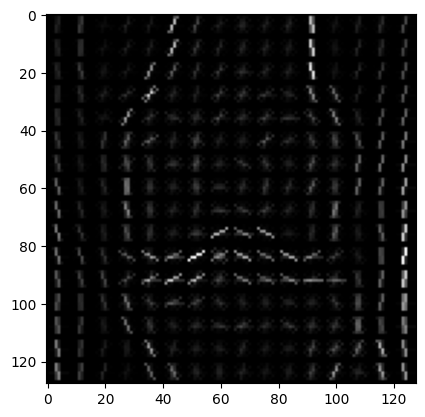

In [32]:
from skimage.exposure import rescale_intensity

hog_rescaled = rescale_intensity(raw_data[0].hog_image)
plt.imshow(hog_rescaled, cmap=plt.cm.gray)


Сохраняем датасет дескрипторов в S3

In [38]:
hog_data = X_data.copy()
hog_data['severity'] = y_target
buffer = io.BytesIO()
hog_data.to_csv(buffer, index=False, compression='gzip')
buffer.seek(0)
s3_client.upload_fileobj(buffer, BUCKET_NAME, 'csv/train_data.csv.gz')


Если нужно быстро получить hog_data, то нужно выполнить только этот блок

In [4]:
import io
buffer = io.BytesIO()
s3_client.download_fileobj(BUCKET_NAME, 'csv/train_data.csv.gz', buffer)
buffer.seek(0)
hog_data = pd.read_csv(buffer, compression='gzip')
X_data = hog_data.drop(columns=['severity'])
y_target = hog_data['severity']


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, stratify=y_target)


Подбираем гиперпараметры для модели SVC

In [ ]:
%pip install scikit-learn-intelex

In [6]:
from sklearnex import patch_sklearn
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

patch_sklearn()

params = {
    'C': np.linspace(1, 100, 3),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'coef0': np.linspace(0, 10, 3),
    'class_weight': [None, 'balanced'],
    'decision_function_shape': ['ovo', 'ovr'],
}
gs_svc_model = GridSearchCV(SVC(probability=True), params, n_jobs=4, verbose=2, scoring='f1', cv=3)
gs_svc_model.fit(X_train, y_train)
gs_svc_model.best_params_, gs_svc_model.best_score_


Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=linear; total time=  10.6s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=poly; total time=  10.1s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=linear; total time=  10.7s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=poly; total time=  10.3s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=poly; total time=  10.7s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=rbf; total time=  12.3s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=linear; total time=  10.8s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, kernel=rbf; total time=  12.4s
[CV] END C=1.0, class_weight=None, coef0=0.0, decision_function_shape=ovo, ke

({'C': 1.0,
  'class_weight': None,
  'coef0': 0.0,
  'decision_function_shape': 'ovo',
  'kernel': 'linear'},
 nan)

In [7]:
gs_svc_model.best_estimator_


SVC(decision_function_shape='ovo', kernel='linear', probability=True)

In [12]:
from sklearn.metrics import f1_score, roc_auc_score
y_pred_proba = gs_svc_model.best_estimator_.predict_proba(X_test)
y_pred = gs_svc_model.best_estimator_.predict(X_test)
print('roc_auc:', roc_auc_score(y_test, y_pred_proba, multi_class='ovo'))
print('f1:', f1_score(y_test, y_pred, average='macro'))


roc_auc: 0.9396017049842017
f1: 0.8683929578887994


Модель показывает неплохие метрики качества. Попробуем использовать градиентный бустинг

In [23]:
!pip install catboost ipywidgets


Looking in indexes: https://pypi.yandex-team.ru/simple/
     |████████████████████████████████| 139 kB 42.9 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 39.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 7.7 MB/s eta 0:00:01


In [14]:
import catboost as cb

cb_model = cb.CatBoostClassifier(
    boosting_type='Plain',
    rsm=0.7,
    one_hot_max_size=50,
    leaf_estimation_iterations=1,
    max_ctr_complexity=1,
    iterations=150,
    learning_rate=0.1,
    bootstrap_type='Bernoulli',
    subsample=0.5
    )
cb_model.fit(
    X_train, 
    y_train,
    verbose=False,
    plot=True,
    eval_set=(X_test, y_test)
    )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
from sklearn.metrics import roc_auc_score, f1_score

y_pred_proba = cb_model.predict_proba(X_test)
y_pred = cb_model.predict(X_test)
print('roc_auc:', roc_auc_score(y_test, y_pred_proba, multi_class='ovo'))
print('f1:', f1_score(y_test, y_pred, average='macro'))


roc_auc: 0.9545492510862397
f1: 0.8026170495165916


In [9]:
cb_model.get_params()


{'learning_rate': 0.1,
 'loss_function': 'MultiClass',
 'logging_level': 'Verbose',
 'max_depth': 5,
 'n_estimators': 1000}

In [19]:
cb_model.save_model('hog_cat_boost.cbm', format="cbm")
s3_client.upload_file('hog_cat_boost.cbm', BUCKET_NAME, 'models/hog_cat_boost.cbm')


In [17]:
!pip install hyperopt


Looking in indexes: https://pypi.yandex-team.ru/simple/
     |████████████████████████████████| 1.6 MB 59.9 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 19.5 MB/s eta 0:00:01
     |████████████████████████████████| 200 kB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 840 kB 9.9 MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /home/tiunovnn/git/hse-knee-xray-research/models/ML/venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/place/vartmp/pip-install-dcduv5ex/future/setup.py'"'"'; __file__='"'"'/place/vartmp/pip-install-dcduv5ex/future/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /place/vartmp/pip-wheel-pssjdwt3
       cwd: /place/vartmp/pip-install-dcduv5ex/future/
  Complete output (6 lines):
  usage: setup.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2

In [ ]:
import numpy as np
from hyperopt import hp, fmin, tpe
from catboost.utils import eval_metric

val_pool = cb.Pool(X_test, y_test)
train_pool = cb.Pool(X_train, y_train)

def hyperopt_objective(params):
    print(params)
    model = cb.CatBoostClassifier(
        loss_function='MultiClass',
        n_estimators=150,
        boosting_type='Plain',
        leaf_estimation_iterations=1,
        max_ctr_complexity=1,
        bootstrap_type='Bernoulli',
        rsm=0.5,
        subsample=0.5,
        **params)
    model.fit(train_pool, verbose=0, eval_set=val_pool)
    y_pred = model.predict_proba(val_pool)
    return -eval_metric(val_pool.get_label(), y_pred, 'AUC')[0]

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'depth': hp.randint('depth', 3, 10),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
}

best = fmin(
    hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials_save_file='hog_cb_trials.bin',
)


{'depth': 3, 'l2_leaf_reg': 1.189793100595091, 'learning_rate': 0.0703029299504435}                                                                                                                 
  3%|████▌                                                                                                                                                  | 3/100 [00:00<?, ?trial/s, best loss=?]

In [21]:
best

{'depth': 9,
 'l2_leaf_reg': 1.2528816275356751,
 'learning_rate': 0.09105057613388456}

In [23]:
model = cb.CatBoostClassifier(
    loss_function='MultiClass',
    n_estimators=1000,
    boosting_type='Plain',
    leaf_estimation_iterations=1,
    max_ctr_complexity=1,
    bootstrap_type='Bernoulli',
    rsm=0.5,
    subsample=0.5,
    depth=9,
    l2_leaf_reg=1.2528816275356751,
    learning_rate=0.02
)
model.fit(train_pool, verbose=0, eval_set=val_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [24]:
from sklearn.metrics import roc_auc_score, f1_score

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)
print('roc_auc:', roc_auc_score(y_test, y_pred_proba, multi_class='ovo'))
print('f1:', f1_score(y_test, y_pred, average='macro'))

roc_auc: 0.981307606099285
f1: 0.8734458769868991


После подбора параметров удалось немного увеличить качество предсказаний. Сохраним эту модель в S3, чтобы в будущем можно было использовать в сервисе

In [25]:
model.save_model('hog_cat_boost_v2.cbm', format="cbm")
s3_client.upload_file('hog_cat_boost_v2.cbm', BUCKET_NAME, 'models/hog_cat_boost_v2.cbm')

Проверим скорость предсказания на одной модели

In [26]:
from skimage.feature import hog
from PIL import Image

def hog_picture(image: io.IOBase):
    image = Image.open(image).convert('L').resize((128, 128))
    array = np.asarray(image)
    vector = hog(
        array,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        feature_vector=True,
    )
    return vector

def predict(image: io.IOBase):
    vector = hog_picture(image)
    severity = model.predict(vector)
    return severity

Для этого используем спорные изображения, который получили разную оценку у экспертов и не использовались при обучении

In [27]:
buffer = io.BytesIO()
s3_client.download_fileobj(BUCKET_NAME, f'{DATASET_DIR}MedicalExpert-II/2Mild/MildG2 (110).png', buffer)
buffer.seek(0)

0

In [29]:
%%timeit
predict(buffer)

17.7 ms ± 466 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Модель предсказывает достаточно быстро для встраивания в API
